<a href="https://colab.research.google.com/github/ravidipu90/self-projects-/blob/main/Video_Activity_Recognition_on_UCF101_DATASET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import resize
from IPython.display import clear_output
from matplotlib.pyplot import imshow #Display images in a plo
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.activations import *
from tensorflow.keras.metrics import *
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import tensorflow as tf
from tensorflow.keras import backend as k
import datetime

Downloading Data

In [ ]:
!wget https://www.crcv.ucf.edu/datasets/human-actions/ucf101/UCF101.rar --no-check-certificate
!unrar x UCF101.rar

Streaming output truncated to the last 5000 lines.
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g06_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c01.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c02.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c03.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c04.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c05.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c06.avi             62%  OK 
Extracting  UCF-101/PlayingGuitar/v_PlayingGuitar_g07_c07.avi             62%  OK 
Extracting  UCF-101/PlayingGu

Download and extract the UCF101 dataset from a URL using wget and unrar, Command respectively.

5 classes , 90 samples per class



In [ ]:
import os
video_path= "/content/UCF-101"  #video_path variable to the directory where the UCF101 dataset is extracted.

target_classes=['PullUps', 'Punch', 'PushUps','RopeClimbing','SkyDiving']
classes,y=[],[]
final_videos=[]
for cls in os.listdir(video_path):
  if cls in target_classes:
    vid_path=os.path.join(video_path,cls)
    videos=[os.path.join(vid_path,vid) for vid in os.listdir(vid_path)][:90]
    classes.append(cls)
    final_videos.extend(videos)

print(classes)
print(len(final_videos))

['SkyDiving', 'PushUps', 'PullUps', 'Punch', 'RopeClimbing']
450


 filter the dataset to include only the specified target classes.iterate through the directory listing in video_path, and for each class in the dataset,collect the paths to the video files (up to 90 videos per class) in the final_videos list and also store the class labels in the classes list.
 and finally  print the class names and the total number of video files collected.

In [ ]:
y = np.array([i//90 for i in range(0,450)])
print(y)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4]


creates an array y that corresponds to the class labels for each video in final_videos.There are 90 videos per class and assigns labels accordingly.

In [ ]:
def read_frames(arr,each_nth=10):
    videos=[]
    for j  in range(len(arr)):
        clear_output()
        print(np.round(100*j/len(arr),3))

        vcap=cv2.VideoCapture(arr[j])
        success=True

        frames=[]
        cnt=0
        while success:
            try:
              success,image=vcap.read()
              cnt+=1
              if cnt%each_nth==0:
                image=resize(image,(128,192))
                frames.append(image)
            except Exception as e:
                print(e)
        videos.append(frames)

    return videos

The read_frames function is designed to read frames from video files in arr, resize them to (128, 192) pixels, and Finally, the function returns a list of lists, where each inner list contains the frames of a single video.

In [ ]:
def select_frames(frames_arr , n=10):
    videos=[]
    for i in range(len(frames_arr)):
        frames=[]
        for t in np.linspace(0, len(frames_arr[i])-1, num=n):
            frames.append(frames_arr[i][int(t)])
        videos.append(frames)

    videos = np.array(videos)
    print(videos.shape)
    return videos

The select_frames function takes an array of frames, frames_arr, and returns a subset of frames by selecting n frames evenly distributed across each video.


In [ ]:
X_frames = read_frames(final_videos)
print(len(X_frames))


99.778
450


call the read_frames function to read frames from the final_videos and store them in X_frames and print the number of videos processed.

In [ ]:
X_frames = select_frames(X_frames, 10)

(450, 10, 128, 192, 3)


call the select_frames function to select 10 frames evenly distributed across each video in X_frames.updates the X_frames variable to contain the selected frames.

In [ ]:
xtr, xte, ytr , yte = train_test_split(X_frames , y , shuffle=True,test_size = 0.3,random_state = 42)

 splits the dataset into training and testing sets using train_test_split from scikit-learn. X_frames contains the selected frames, y contains the corresponding class labels, and the split is performed with a 70% training and 30% testing ratio. The shuffle parameter ensures that the data is shuffled before splitting, and random_state sets the seed for reproducibility.

In [ ]:
ytr = to_categorical(ytr, 10)
yte = to_categorical(yte,10)

 convert the class labels ytr and yte to one-hot encoded format using to_categorical from Keras.common preprocessing step for classification tasks.

Random Sample Visualization

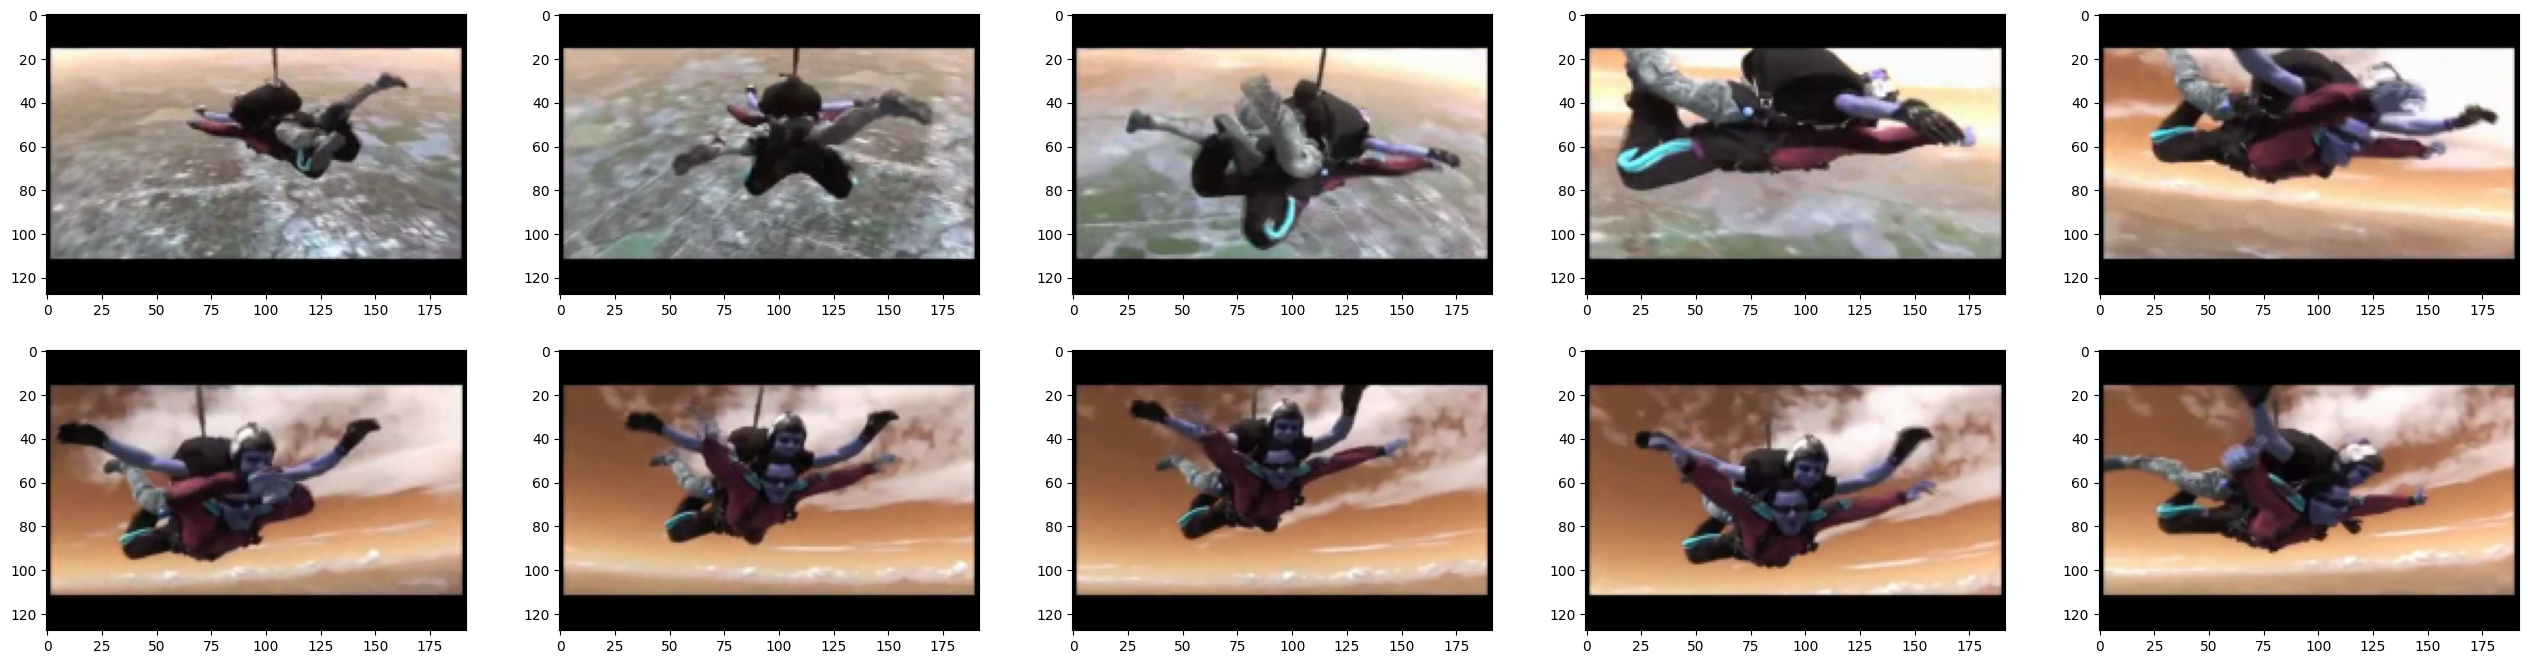

In [ ]:
fig = plt.figure(figsize=(32,8))

random_video_index = np.random.randint(0,len(X_frames))

for i,image in enumerate(X_frames[random_video_index]):
    ax = plt.subplot(2,5,i+1)
    imshow(image)

  create a plot to visualize a random video from the selected frames (X_frames).randomly select a video index, retrieve its frames, and display them using Matplotlib.  visualization and can help inspect the frames.

Building model

In [ ]:
def list_to_stack(xs):
  xs=tf.stack(xs, axis=1)
  s = tf.shape(xs)

  return xs

list_to_stack function used for to convert a list of tensors into a single stacked tensor

In [ ]:
ish=(10, 128, 192, 3) #

xs=[]


inp = Input(ish)

for slice_indx in range(0,10,1):
  x=Lambda(lambda x: x[:, slice_indx])(inp)
  x=BatchNormalization(momentum=0.8)(x)
  x=Conv2D(filters=20, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)

  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)
  x=BatchNormalization(momentum=0.8)(x)
  x=MaxPooling2D(pool_size=2)(x)
  x=Conv2D(filters=30, kernel_size=3, padding='same', activation='relu')(x)

  xs.append(x)


t=Lambda(list_to_stack)(xs)
t=Conv3D(50,3,padding='same')(t)
t=BatchNormalization(momentum=0.8)(t)
target_shape=(10,32*48*50)
t=Reshape(target_shape)(t)
t=GRU(25, return_sequences=True)(t)
t=GRU(50, return_sequences=False,dropout=0.5)(t)

t=Dense(100,'relu')(t)
out=Dense(10, activation='softmax')(t)

model = Model(inputs=inp, outputs=out)
opt = tf.keras.optimizers.SGD(lr=0.0087)
model.compile(loss = "categorical_crossentropy", optimizer = opt, metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 128, 192, 3)]    0         []                            
                                                                                                  
 lambda (Lambda)             (None, 128, 192, 3)          0         ['input_1[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 128, 192, 3)          0         ['input_1[0][0]']             
                                                                                                  
 lambda_2 (Lambda)           (None, 128, 192, 3)          0         ['input_1[0][0]']             
                                                                                              

** #model architecture **

ish is a tuple representing the input shape of the model. It indicates that
each input will be a sequence of 10 frames, where each frame has dimensions (128, 192) with 3 color channels (RGB).

xs is an empty list that will be used to store intermediate feature maps from convolutional layers.

inp defines the input layer for the model with the specified shape.

A loop iterates over each time step (frame) in the sequence, from 0 to 9.
Lambda is used to extract the slice_indx-th frame from the input sequence.

It effectively slices the input tensor to get the frame at the current time step.

BatchNormalization is applied to the sliced frame. Batch normalization helps in stabilizing and speeding up training by normalizing the inputs.

A 2D convolutional layer (Conv2D) is applied to each sliced frame with 20 filters, a kernel size of 3x3, 'same' padding to preserve spatial dimensions, and ReLU activation.

Batch normalization is applied again to the convolutional output.
Max-pooling with a pool size of 2x2 is used to downsample the feature maps, reducing their spatial dimensions.

Another set of convolutional layers is applied, similar to the previous block.
Two consecutive Conv2D layers with 30 filters and ReLU activation are applied.
Batch normalization is applied after each Conv2D layer.

Max-pooling with a pool size of 2x2 is used again to downsample the feature maps.

The final Conv2D layer is applied, and the resulting feature map is added to the xs list.

Lambda is used to stack the feature maps from the xs list into a 3D tensor. This tensor will have dimensions (batch_size, 10, height, width, channels), where 10 corresponds to the 10 time steps (frames).

A 3D convolutional layer (Conv3D) is applied to the stacked feature maps with 50 filters, a kernel size of 3x3x3, and 'same' padding to preserve dimensions.
Batch normalization is applied to the output of the 3D convolution.

The output of the 3D convolution is reshaped into a 2D tensor with dimensions (batch_size, 10, 324850). This flattens the spatial dimensions and keeps the 10 time steps.

Two GRU (Gated Recurrent Unit) layers are applied to the reshaped tensor. The first GRU layer has 25 units and returns sequences, while the second GRU layer has 50 units and doesn't return sequences.

A dropout layer with a dropout rate of 0.5 is applied after the second GRU layer. Dropout helps prevent overfitting.

Two fully connected (Dense) layers are applied. The first Dense layer has 100 units with ReLU activation.

The second Dense layer has 10 units (equal to the number of classes) with a softmax activation function, making it suitable for multi-class classification. This layer outputs class probabilities.

Finally, a Keras Model is created, specifying the input (inp) and output (out) layers.

The model is compiled with the SGD (Stochastic Gradient Descent) optimizer with a learning rate of 0.0087.

Categorical cross-entropy is used as the loss function, which is common for multi-class classification tasks.

'accuracy' is specified as a metric to monitor during training.

Model design

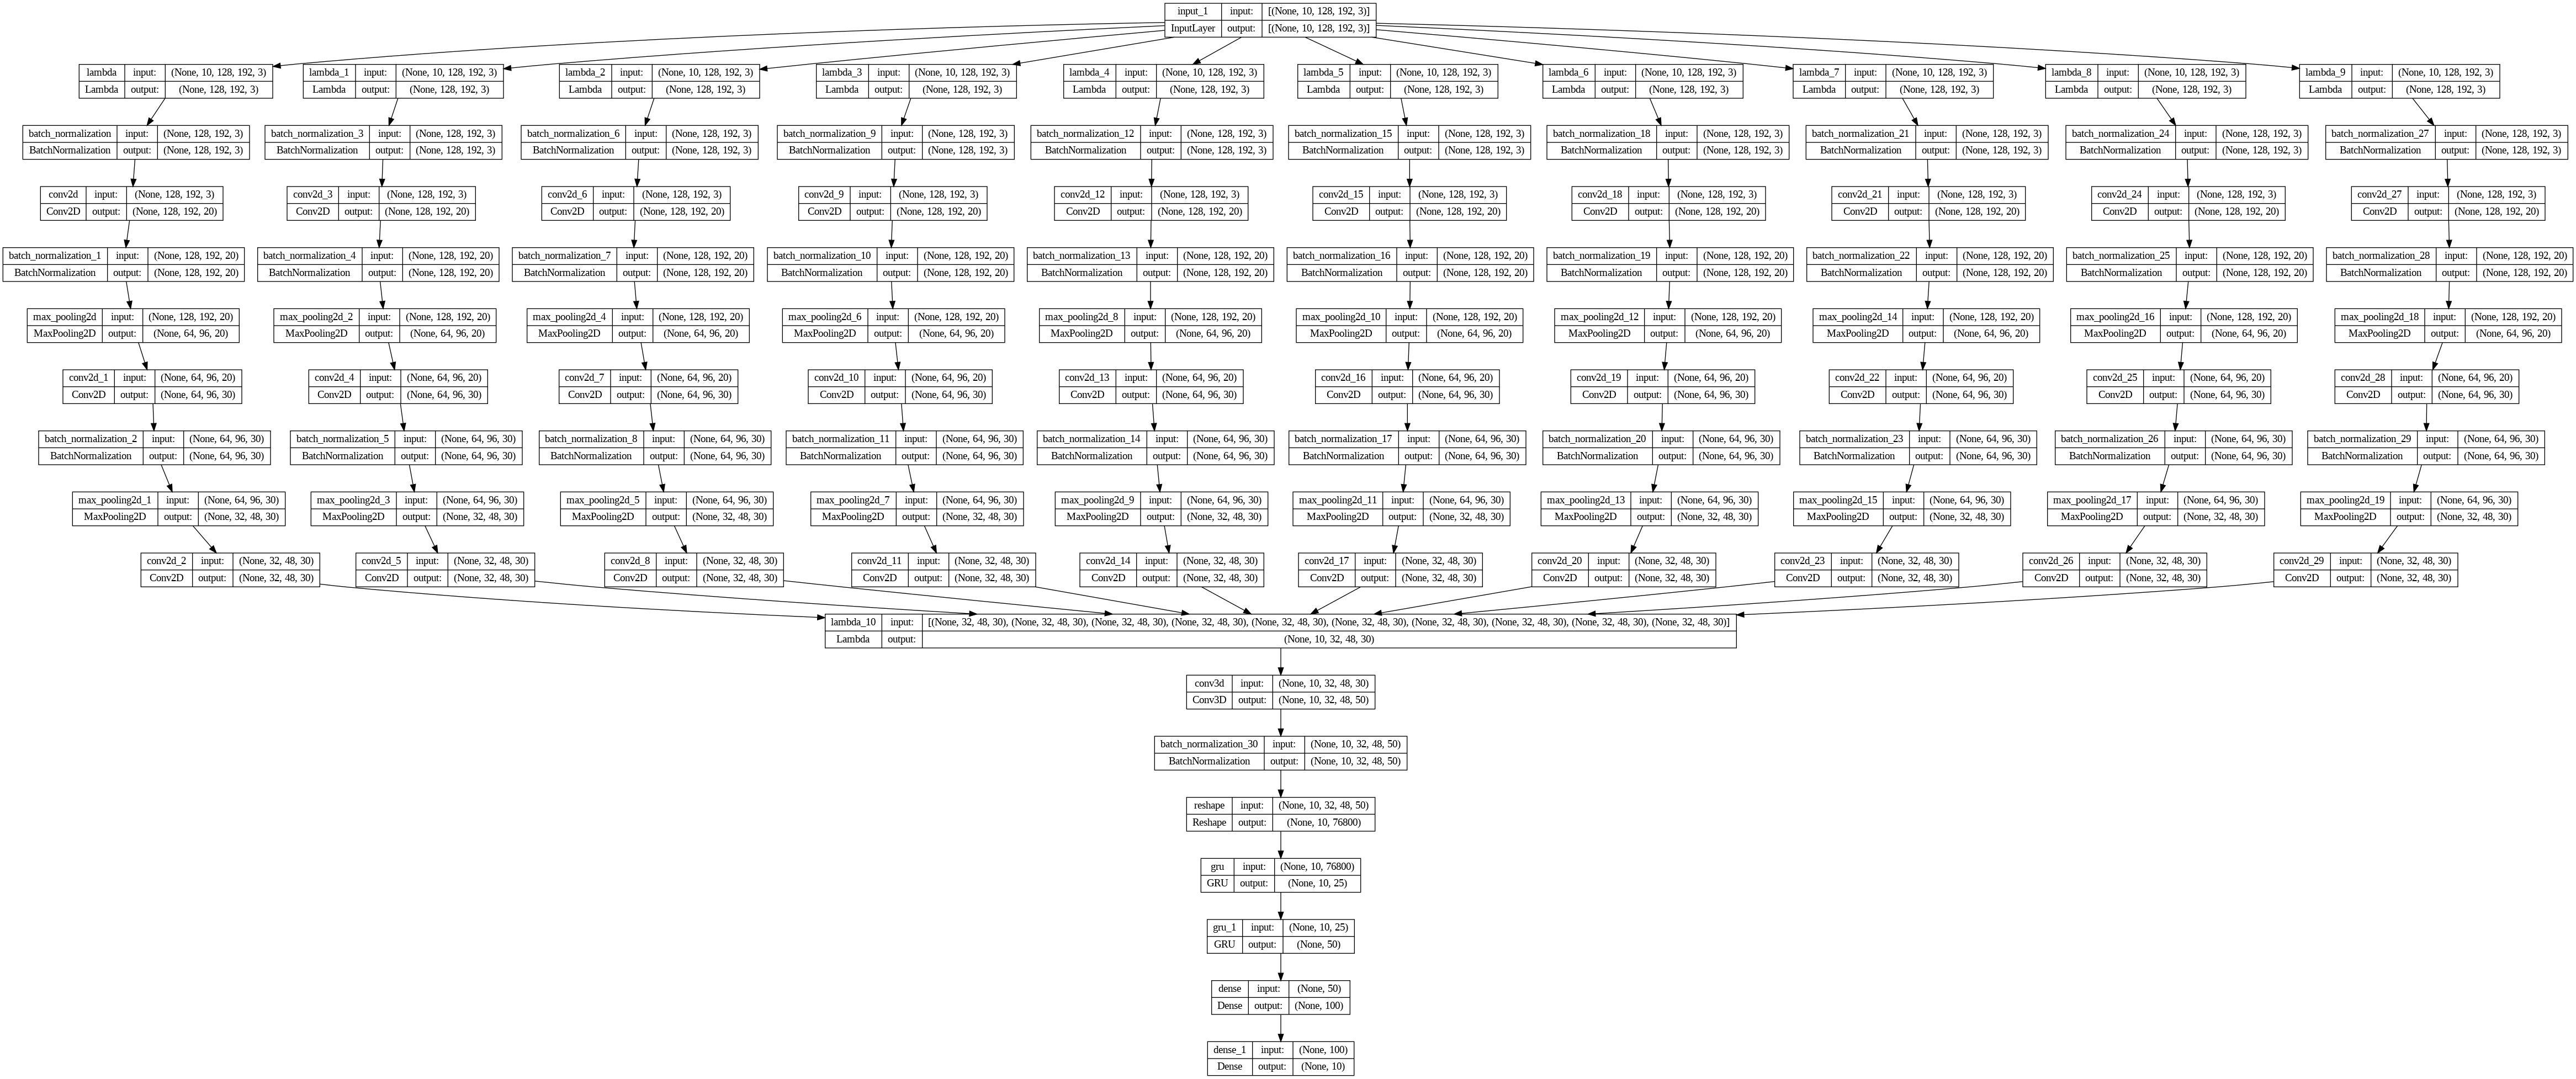

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

 model Training

In [ ]:
history = model.fit(xtr, ytr, epochs=8, batch_size=5,validation_data=(xte, yte),shuffle  = True)

Epoch 1/8
63/63 [==============================] - 33s 134ms/step - loss: 1.7859 - accuracy: 0.4254 - val_loss: 1.4132 - val_accuracy: 0.5333
Epoch 2/8
63/63 [==============================] - 3s 53ms/step - loss: 1.1565 - accuracy: 0.7365 - val_loss: 1.1383 - val_accuracy: 0.5704
Epoch 3/8
63/63 [==============================] - 3s 55ms/step - loss: 0.8029 - accuracy: 0.8286 - val_loss: 0.8103 - val_accuracy: 0.7556
Epoch 4/8
63/63 [==============================] - 4s 56ms/step - loss: 0.5156 - accuracy: 0.9143 - val_loss: 0.6728 - val_accuracy: 0.7852
Epoch 5/8
63/63 [==============================] - 3s 53ms/step - loss: 0.3602 - accuracy: 0.9460 - val_loss: 0.6053 - val_accuracy: 0.7778
Epoch 6/8
63/63 [==============================] - 3s 52ms/step - loss: 0.2650 - accuracy: 0.9397 - val_loss: 0.5918 - val_accuracy: 0.8074
Epoch 7/8
63/63 [==============================] - 3s 55ms/step - loss: 0.1631 - accuracy: 0.9810 - val_loss: 0.5404 - val_accuracy: 0.8148
Epoch 8/8
63/63 [=

Model performance Visualization

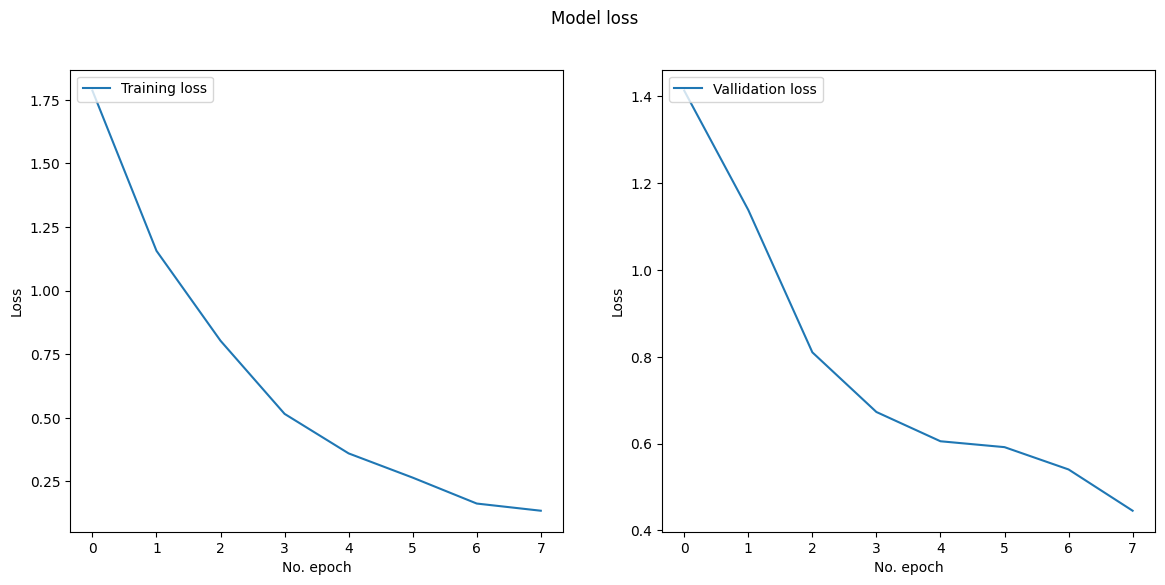

In [ ]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training loss')
ax.legend(loc="upper left")
plt.ylabel('Loss')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_loss'], label='Vallidation loss')
ax.legend(loc="upper left")
fig.suptitle('Model loss')
plt.ylabel('Loss')
plt.xlabel('No. epoch')
plt.show()

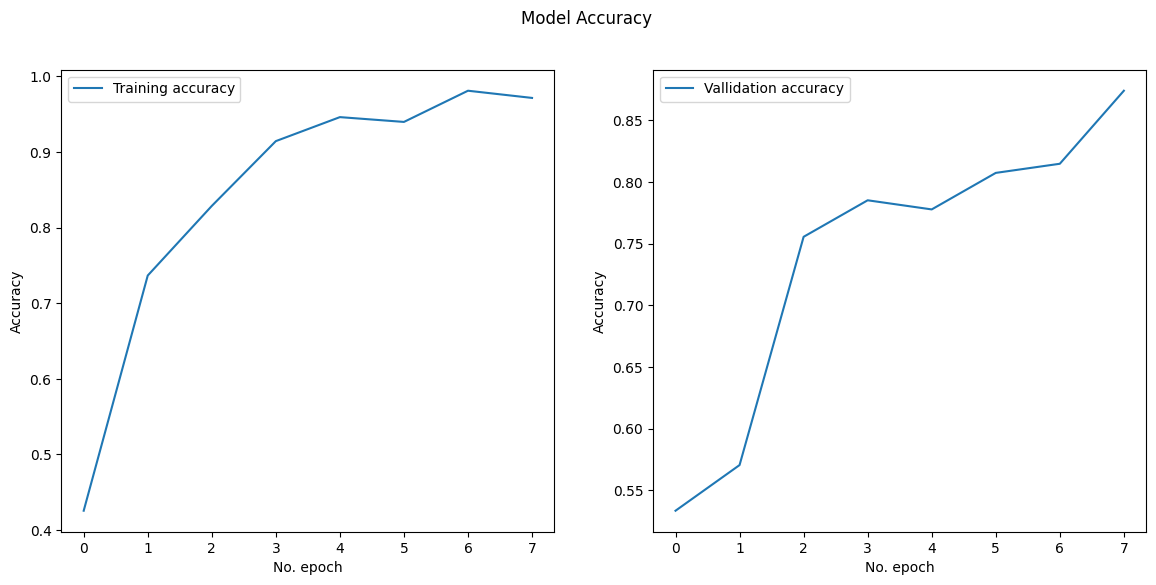

In [ ]:
fig = plt.figure(figsize=(14,6))

ax = plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training accuracy')
ax.legend(loc="upper left")
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
ax = plt.subplot(1,2,2)
plt.plot(history.history['val_accuracy'], label='Vallidation accuracy')
ax.legend(loc="upper left")
fig.suptitle('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('No. epoch')
plt.show()

Model demonstration

Take 10 random videos from test set and show predicted activity on them. For demonstration purposes I show only 1 frame from each video

In [ ]:
random_videos = np.random.randint(0,len(xte),size=(10))
predicted  = model.predict(xte[random_videos],batch_size = 10)
predicted  = np.argmax(predicted,axis=1)

1/1 [==============================] - 2s 2s/step


In [ ]:
print(predicted)

[2 0 0 0 4 0 3 4 1 3]


['SkyDiving', 'PushUps', 'PullUps', 'Punch', 'RopeClimbing']
PullUps
SkyDiving
SkyDiving
SkyDiving
RopeClimbing
SkyDiving
Punch
RopeClimbing
PushUps
Punch


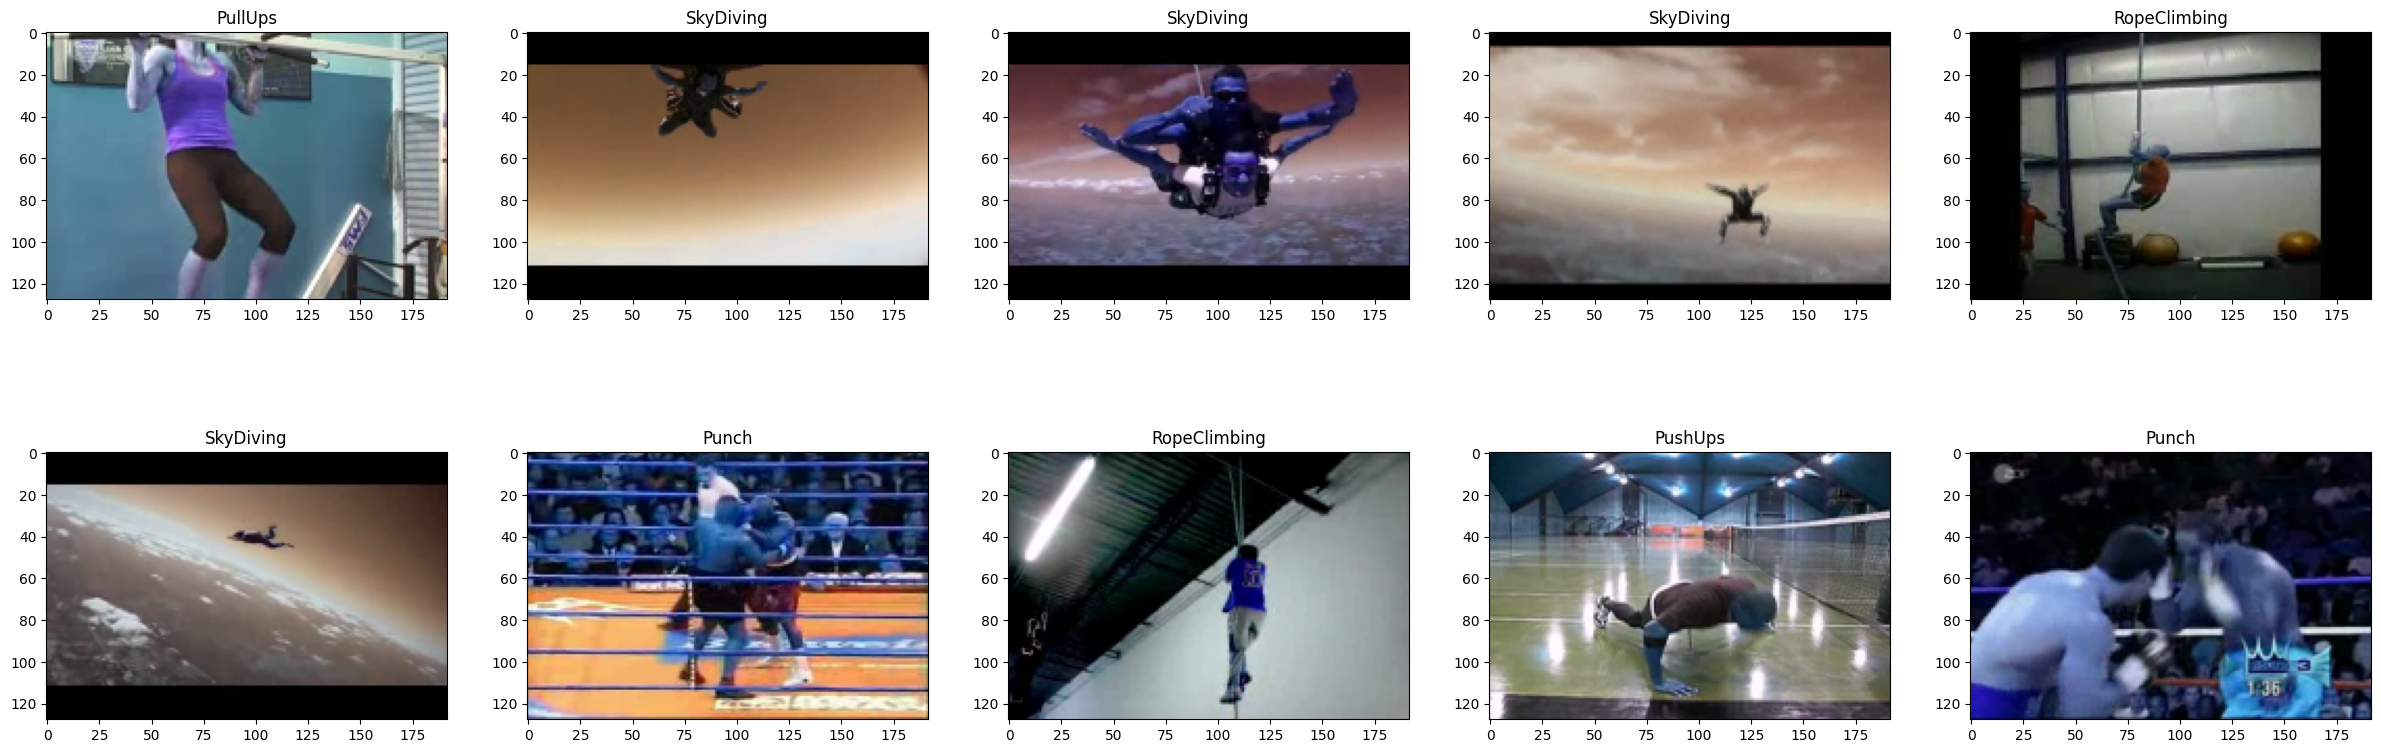

In [ ]:
fig = plt.figure(figsize=(30,10))
print(classes)

for i,rand_indx in enumerate(random_videos):
    ax = plt.subplot(2,5,i+1)
    video = xte[rand_indx]
    frame = video[np.random.randint(0,10)]
    print(classes[predicted[i]])
    ax.set_title(classes[predicted[i]])
    imshow(frame)